In [ ]:
import os
import imageio.v3 as iio
import numpy as np
from redis import Redis
from redisvl.index import SearchIndex
from redisvl.schema import IndexSchema
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from PIL import Image
import json
from redisvl.redis.utils import buffer_to_array
import logging

# Set level to only show errors
logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger()


def load_manifest(manifest_path):
    with open(manifest_path, "r") as f:
        manifest = json.load(f)
    return manifest


manifest_path = r"D:\\TCGA-LUAD\\manifest.json"
manifest = load_manifest(manifest_path)

data_dir = "D:\\TCGA-LUAD"

client = Redis.from_url("redis://10.0.1.16:6379")
client.flushall()

model = SentenceTransformer("clip-ViT-L-14")

with open("schema.json", "r") as f:
    schema_json = json.load(f)

schema = IndexSchema.from_dict(schema_json)
index = SearchIndex(schema, client)
index.create()


def process_and_load(series, model, data_dir, patient_id):
    path = os.path.join(
        data_dir,
        "raw",
        patient_id,
        "CT",
        series["SeriesInstanceUID"],
        series["SeriesInstanceUID"],
    )
    try:
        vol = iio.imread(path, plugin="DICOM")
        images = (
            [Image.fromarray(slice) for slice in vol]
            if vol.ndim == 3
            else [Image.fromarray(vol)]
        )
        emb = model.encode(images, batch_size=32, convert_to_tensor=True)
        emb = emb.cpu().numpy()  # Move to CPU and convert to numpy
        emb = np.mean(emb, axis=0)  # Aggregate embeddings if there are multiple slices
        emb = buffer_to_array(emb, dtype=np.float32)
        series["radiology_embedding"] = emb
        series["PatientID"] = patient_id
        logger.info(f"{vol.shape} -> {len(emb)}")
    except Exception as e:
        logger.error(
            f"Error processing series {series['SeriesInstanceUID']} for patient {patient_id}: {e}"
        )


for patient in tqdm(manifest, desc="Uploading to redis"):
    if patient.get("CT"):
        patient_id = patient["PatientID"]
        all_series_info = patient.get("CT")
        for series in all_series_info:
            process_and_load(series, model, data_dir, patient_id)
        index.load(all_series_info)

In [ ]:
import json
import jsonlines

with open("D:\\TCGA-LUAD\\manifest.json", "r") as f:
    manifest = json.load(f)

for patient in manifest:
    patient_id = patient["PatientID"]
    gdc_case_id = patient["gdc_case_id"]
    for data_type in patient:
        if data_type != "PatientID" and data_type != "gdc_case_id":
            data = patient[data_type]
            with jsonlines.open(f"./data/json/{data_type}.jsonl", "a") as writer:
                for data_item in data:
                    data_item["PatientID"] = patient_id
                    data_item["gdc_case_id"] = gdc_case_id
                    writer.write(data_item)

In [ ]:
import json
import pandas as pd

# Define the directory for output CSV files
output_dir = "./data/dataframe/"
os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists

# Load your manifest JSON file
with open("D:\\TCGA-LUAD\\manifest.json", "r") as f:
    manifest = json.load(f)

# Initialize a dictionary to hold data for each data type
data_frames = {}

# Process each patient in the manifest
for patient in manifest:
    patient_id = patient["PatientID"]
    gdc_case_id = patient["gdc_case_id"]

    for data_type in patient:
        if data_type not in ["PatientID", "gdc_case_id"]:
            # Convert the list of dictionaries into a DataFrame
            df = pd.DataFrame(patient[data_type])
            # Add 'PatientID' and 'gdc_case_id' columns
            df["PatientID"] = patient_id
            df["gdc_case_id"] = gdc_case_id

            # If this data type has not been seen before, initialize it in the dictionary
            if data_type not in data_frames:
                data_frames[data_type] = df
            else:
                # Append the new data to the existing DataFrame for this data type
                data_frames[data_type] = pd.concat(
                    [data_frames[data_type], df], ignore_index=True
                )

# Once all data has been processed, save each DataFrame to a CSV file
for data_type, df in data_frames.items():
    file_path = os.path.join(output_dir, f"{data_type}.csv")
    df.to_csv(file_path, index=False)

In [ ]:
# load a single patient's
import pandas as pd


for file in os.listdir("./data/dataframe"):
    try:
        df = pd.read_csv(f"./data/dataframe/{file}")
    except Exception as e:
        print(f"Failed to load {file}: {e}")
    else:
        print(f"Loaded {file} with {len(df)} rows")

---

(585, 1024)


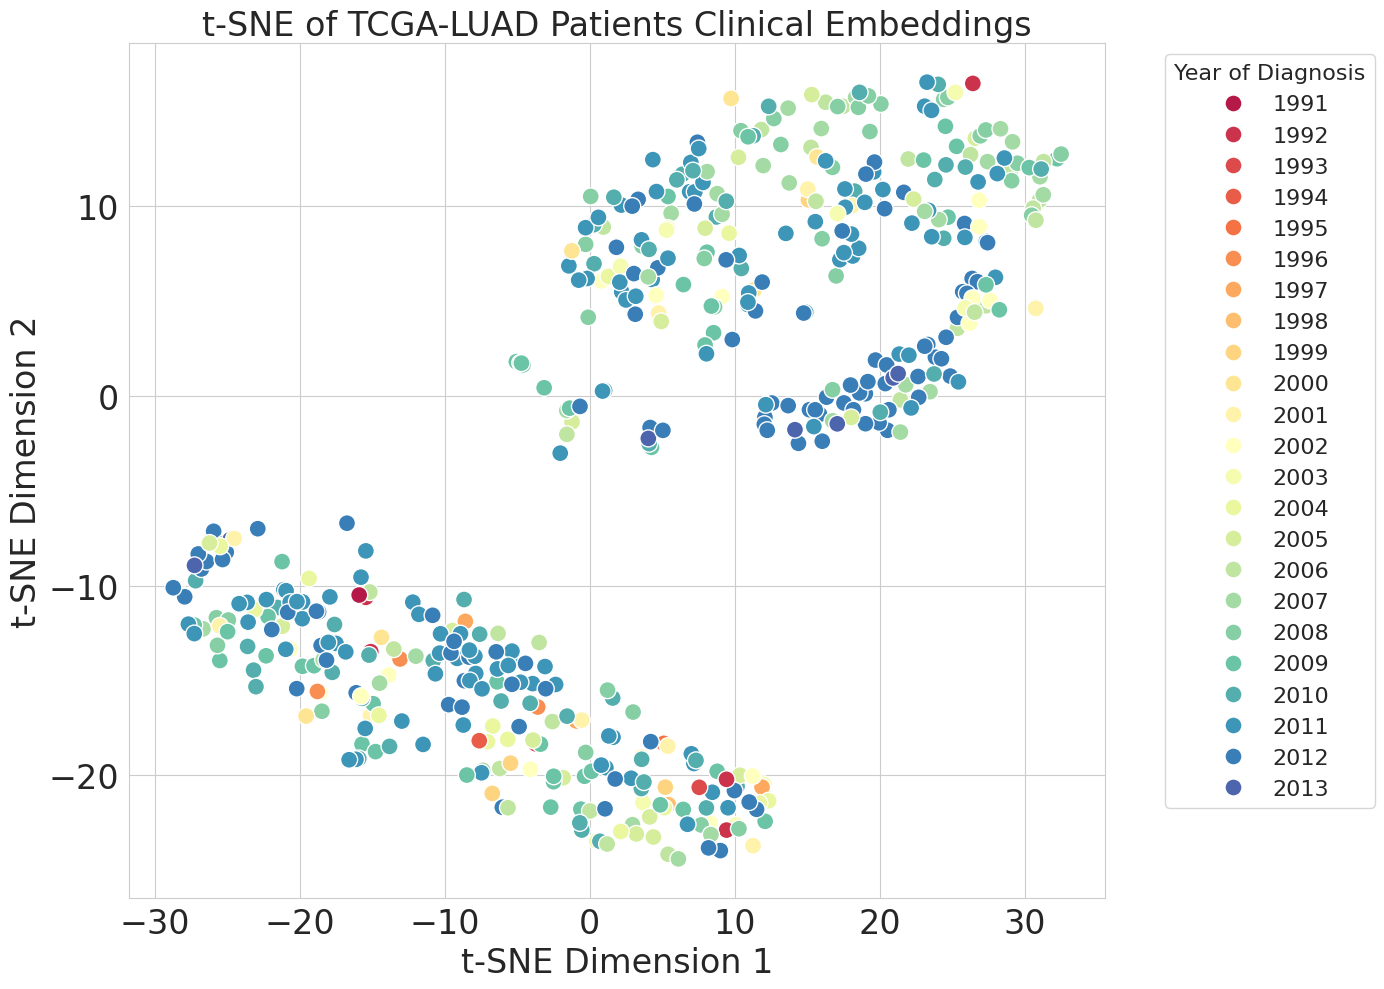

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

df = pd.read_parquet("./data/parquet/clinical.parquet")
embeddings_series = df["clinical_embedding"]

all_embeddings = []
for i in range(len(embeddings_series)):
    embeddings_objects = np.array(embeddings_series[i].tolist(), dtype=object)
    all_embeddings.append(embeddings_objects)
all_embeddings = np.array(all_embeddings).reshape(-1, 1024)
print(all_embeddings.shape)

tsne = TSNE(n_components=2, random_state=0)
tsne_obj = tsne.fit_transform(all_embeddings)

tsne_df = pd.DataFrame(
    {
        "X": tsne_obj[:, 0],
        "Y": tsne_obj[:, 1],
        "label": df["year_of_diagnosis"],
    }
)
# Filter out None values, then sort and set as categories
valid_labels = tsne_df["label"].dropna().unique()
sorted_labels = sorted(valid_labels, key=lambda x: (str(x).isdigit(), x))

# Set the 'label' column as an ordered categorical type with the sorted labels
tsne_df["label"] = pd.Categorical(
    tsne_df["label"], ordered=True, categories=sorted_labels
)

# Proceed with plotting
plt.figure(figsize=(14, 10))
sns.scatterplot(
    x="X",
    y="Y",
    data=tsne_df,
    hue="label",
    legend="full",
    palette="Spectral",
    alpha=1,
    marker="o",
    s=150,
)
plt.title(
    "t-SNE of TCGA-LUAD Patients Clinical Embeddings", fontsize=24
)  # Larger title font size
plt.xlabel("t-SNE Dimension 1", fontsize=24)  # X-axis label with font size
plt.ylabel("t-SNE Dimension 2", fontsize=24)  # Y-axis label with font size
plt.xticks(fontsize=24)  # Larger x-tick labels
plt.yticks(fontsize=24)  # Larger y-tick labels
plt.grid(True)  # Add gridlines
plt.legend(
    title="Year of Diagnosis",
    title_fontsize="16",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=16,
)
sns.set_style("whitegrid")
plt.tight_layout()
plt.show()

In [4]:
from datasets import load_dataset

pathology_report_dataset = load_dataset(
    "Aakash-Tripathi/TCGA-LUAD-minds", "pathology_report"
)
print(pathology_report_dataset)

clinical_dataset = load_dataset("Aakash-Tripathi/TCGA-LUAD-minds", "clinical")
print(clinical_dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'data_format', 'access', 'file_name', 'md5sum', 'updated_datetime', 'data_type', 'data_category', 'state', 'type', 'file_size', 'created_datetime', 'PatientID', 'gdc_case_id', 'report_text', 'report_embedding'],
        num_rows: 523
    })
})
DatasetDict({
    train: Dataset({
        features: ['project_id', 'case_id', 'case_submitter_id', 'state', 'normal_tumor_genotype_snp_match', 'ribosomal_rna_28s_16s_ratio', 'spectrophotometer_method', 'age_at_index', 'days_to_birth', 'ethnicity', 'gender', 'race', 'vital_status', 'year_of_birth', 'age_at_diagnosis', 'ajcc_pathologic_m', 'ajcc_pathologic_n', 'ajcc_pathologic_stage', 'ajcc_pathologic_t', 'ajcc_staging_system_edition', 'classification_of_tumor', 'days_to_diagnosis', 'icd_10_code', 'last_known_disease_status', 'morphology', 'primary_diagnosis', 'prior_malignancy', 'prior_treatment', 'progression_or_recurrence', 'site_of_resection_or_biopsy', 'synchronous_malignancy', 'tiss

In [5]:
clinical_dataset["train"].to_pandas().head()

,project_id,case_id,case_submitter_id,state,normal_tumor_genotype_snp_match,ribosomal_rna_28s_16s_ratio,spectrophotometer_method,age_at_index,days_to_birth,ethnicity,...,analyte_type_id,rna_integrity_number,days_to_collection,initial_weight,section_location,concentration,slide_id,slide_submitter_id,aliquot_quantity,aliquot_volume
0,TCGA-LUAD,34040b83-7e8a-4264-a551-b16621843e28,TCGA-05-4244,released,Yes,1.5,UV Spec,70,-25752,not reported,...,None,None,None,None,None,None,None,None,None,None
1,TCGA-LUAD,03d09c05-49ab-4ba6-a8d7-e7ccf71fafd2,TCGA-05-4245,released,Yes,None,UV Spec,81,-29647,not reported,...,None,None,None,None,None,None,None,None,None,None
2,TCGA-LUAD,4addf05f-3668-4b3f-a17f-c0227329ca52,TCGA-05-4249,released,Yes,None,UV Spec,67,-24532,not reported,...,None,None,None,None,None,None,None,None,None,None
3,TCGA-LUAD,f98ecd8a-b878-4f53-b911-20cd8e17281c,TCGA-05-4250,released,Yes,None,None,79,-29068,not reported,...,None,None,None,None,None,None,None,None,None,None
4,TCGA-LUAD,3434b91a-c05f-460f-a078-7b1bb6e7085d,TCGA-05-4382,released,Yes,None,UV Spec,68,-24868,not reported,...,None,None,None,None,None,None,None,None,None,None


In [7]:
pathology_report_dataset["train"].to_pandas().head()

,id,data_format,access,file_name,md5sum,updated_datetime,data_type,data_category,state,type,file_size,created_datetime,PatientID,gdc_case_id,report_text,report_embedding
0,986c5a54-1515-4e4c-883f-756c83615926,PDF,open,TCGA-62-A471.5F2495BD-2398-4C97-8F3E-76E979F22...,bba0fec58ca4779898310d2a381bc28b,2022-11-01T11:54:18.907708-05:00,Pathology Report,Clinical,released,pathology_report,51989,2022-10-10T14:11:35.314413-05:00,TCGA-62-A471,0075437e-ba1a-46be-86d6-9773209a2b5e,UUID:5F2495BD-2398-4097-BF3E-76E979F22691\nTCG...,"[[-0.18897301, 0.0577072, -0.18365583, -0.1675..."
1,5dee7d42-d502-4b8a-b2f5-716386cb9f07,PDF,open,TCGA-67-3773.E5B82F07-698E-4DFF-9D33-748790E40...,2e492879f0ac0ab08e5e75aa45099a2d,2022-11-01T11:54:18.907708-05:00,Pathology Report,Clinical,released,pathology_report,258698,2022-10-10T14:11:35.314413-05:00,TCGA-67-3773,009be09b-f9f6-43b7-8f45-4a648f8123ce,TISSUES: \nA. LYMPH NODE \nB. LYMPH NODE \nc. ...,"[[-0.04848309, -0.075115696, -0.29123232, -0.0..."
2,2f4abaf5-ce78-42df-b379-5f54e1a05440,PDF,open,TCGA-NJ-A7XG.8EFDF414-12F3-4DF8-BB21-9E8876B72...,84e52af2feae25e2a6360b38a28649bb,2022-11-01T11:54:18.907708-05:00,Pathology Report,Clinical,released,pathology_report,224307,2022-10-10T14:11:35.314413-05:00,TCGA-NJ-A7XG,01e9888d-b5b9-48f1-8ba6-8a89af108a04,UUID:BEFDF414-12F3- 4DF8-BB21 -9E8876B727E8\nT...,"[[-0.014459765, 0.018634148, -0.42192563, -0.0..."
3,ec324506-20cb-442c-9ef1-2e6889e0e665,PDF,open,TCGA-91-6848.A790E051-B741-4913-AFF6-5A48C9E8E...,5ca08ca5bba110a1d7468c7364acf9fd,2022-11-01T11:54:18.907708-05:00,Pathology Report,Clinical,released,pathology_report,22275,2022-10-10T14:11:35.314413-05:00,TCGA-91-6848,0232d299-4cdf-4fd7-9a5e-8d13c208b40c,\nFinal Pathologic Diagnosis: \nA. Anterior l...,"[[-0.1028039, 0.030365033, -0.416276, -0.26815..."
4,cc79f874-81cb-4653-a800-b985b7267332,PDF,open,TCGA-55-6986.BC8C1075-8F74-42DA-BC09-80B4152B1...,b955e2ccbe55a5374dd6f5e1dad1a2a1,2022-11-01T11:54:18.907708-05:00,Pathology Report,Clinical,released,pathology_report,125903,2022-10-10T14:11:35.314413-05:00,TCGA-55-6986,028e99e9-5b9a-4954-bb6e-6d4709a3cea8,Surgical Pathology \nHistopathological Ex~mina...,"[[0.2902648, -0.11651442, -0.120281115, -0.040..."


(523, 1024)


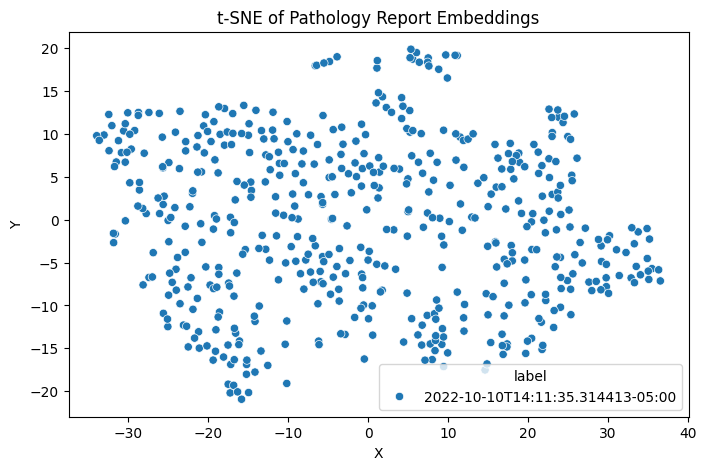

In [16]:
# plot the embeddings from the pathology report dataset by the created_datetime column

---

In [ ]:
import pandas as pd
from typing import List
import wget
import zipfile
import pandas as pd
from ollama import Client


def download_wikipedia_data(
    data_path: str = "../../data/",
    download_path: str = "./",
    file_name: str = "vector_database_wikipedia_articles_embedded",
) -> pd.DataFrame:
    data_url = "https://cdn.openai.com/API/examples/data/vector_database_wikipedia_articles_embedded.zip"

    csv_file_path = os.path.join(data_path, file_name + ".csv")
    zip_file_path = os.path.join(download_path, file_name + ".zip")
    if os.path.isfile(csv_file_path):
        print("File Downloaded")
    else:
        if os.path.isfile(zip_file_path):
            print("Zip downloaded but not unzipped, unzipping now...")
        else:
            print("File not found, downloading now...")
            # Download the data
            wget.download(data_url, out=download_path)

        # Unzip the data
        with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
            zip_ref.extractall(data_path)

        # Remove the zip file
        os.remove("vector_database_wikipedia_articles_embedded.zip")
        print(f"File downloaded to {data_path}")


def read_wikipedia_data(
    data_path: str = "../../data/",
    file_name: str = "vector_database_wikipedia_articles_embedded",
) -> pd.DataFrame:
    csv_file_path = os.path.join(data_path, file_name + ".csv")
    data = pd.read_csv(csv_file_path)

    if "title_vector" in data.columns:
        data = data.drop(columns=["title_vector"])
    if "content_vector" in data.columns:
        data = data.drop(columns=["content_vector"])
    if "vector_id" in data.columns:
        data = data.drop(columns=["vector_id"])

    # save only the first 500 rows
    data = data.head(500)

    client = Client(host="http://localhost:11434")
    client.pull("all-minilm")

    data["title_vector"] = ""
    data["content_vector"] = ""
    for i, row in data.iterrows():
        title_embedding = client.embeddings(model="all-minilm", prompt=row["title"])[
            "embedding"
        ]
        content_embedding = client.embeddings(model="all-minilm", prompt=row["text"])[
            "embedding"
        ]
        # add the embeddings to the dataframe
        data.at[i, "title_vector"] = title_embedding
        data.at[i, "content_vector"] = content_embedding

    # save the data to a csv file
    data.to_csv(data_path + file_name + ".csv", index=False)
    return data


download_wikipedia_data()
data = read_wikipedia_data()
data.head()

In [ ]:
import redis
from redis.commands.search.indexDefinition import IndexDefinition, IndexType
from redis.commands.search.query import Query
from redis.commands.search.field import TextField, VectorField


data = pd.read_csv(r"F:\Projects\HoneyBee\data\dataframe\Pathology Report.csv")

# add to the data dataframe the column "extracted_text" and "extracted_text_embedding"
data["extracted_text"] = ""
data["extracted_text_embedding"] = ""


REDIS_HOST = "10.0.1.16"
REDIS_PORT = 6379
REDIS_PASSWORD = ""  # default for passwordless Redis

# Connect to Redis
redis_client = redis.Redis(host=REDIS_HOST, port=REDIS_PORT, password=REDIS_PASSWORD)
redis_client.ping()

# Constants
VECTOR_DIM = 1024  # length of the vectors
VECTOR_NUMBER = len(data)  # initial number of vectors
INDEX_NAME = "embeddings-index"  # name of the search index
PREFIX = "pathology_report"  # prefix for the document keys
DISTANCE_METRIC = "COSINE"  # distance metric for the vectors (ex. COSINE, IP, L2)

# # Define RediSearch fields for each of the columns in the dataset
# title = TextField(name="title")
# url = TextField(name="url")
# text = TextField(name="extracted_text")
# extracted_text_embedding = VectorField(
#     "extracted_text_embedding",
#     "FLAT",
#     {
#         "TYPE": "FLOAT32",
#         "DIM": VECTOR_DIM,
#         "DISTANCE_METRIC": DISTANCE_METRIC,
#         "INITIAL_CAP": VECTOR_NUMBER,
#     },
# )
# fields = [title, url, text, extracted_text_embedding]

# Assuming 'data' is your DataFrame
fields = []
# Dynamically add TextField for each column, except for special handling columns
for column in data.columns:
    if column not in ["extracted_text", "extracted_text_embedding"]:
        fields.append(TextField(name=column))
# Add special fields for 'extracted_text' and 'extracted_text_embedding'
fields.append(TextField(name="extracted_text"))
fields.append(
    VectorField(
        "extracted_text_embedding",
        "FLAT",
        {
            "TYPE": "FLOAT32",
            "DIM": VECTOR_DIM,
            "DISTANCE_METRIC": DISTANCE_METRIC,
            "INITIAL_CAP": VECTOR_NUMBER,
        },
    )
)

# Check if index exists
try:
    redis_client.ft(INDEX_NAME).info()
    print("Index already exists")
    # drop the index
    redis_client.flushall()
    print("Index dropped")
    # Create RediSearch Index
    redis_client.ft(INDEX_NAME).create_index(
        fields=fields,
        definition=IndexDefinition(prefix=[PREFIX], index_type=IndexType.HASH),
    )
    print("Index created")
except:
    # Create RediSearch Index
    redis_client.ft(INDEX_NAME).create_index(
        fields=fields,
        definition=IndexDefinition(prefix=[PREFIX], index_type=IndexType.HASH),
    )
    print("Index created")

## Load documents into the index

In [ ]:
def index_documents(client: redis.Redis, prefix: str, documents: pd.DataFrame):
    records = documents.to_dict("records")
    for doc in records:
        key = f"{prefix}:{str(doc['id'])}"

        # create byte vectors for title and content
        # extracted_text_embedding = np.array(
        #     doc["extracted_text_embedding"], dtype=np.float32
        # ).tobytes()

        # replace list of floats with byte vectors
        # doc["extracted_text_embedding"] = extracted_text_embedding
        client.hset(key, mapping=doc)


index_documents(redis_client, PREFIX, data)
print(
    f"Loaded {redis_client.info()['db0']['keys']} documents in Redis search index with name: {INDEX_NAME}"
)

## Simple Vector Search Queries with Ollama Query Embeddings

In [ ]:
from ollama import Client

client = Client(host="http://localhost:11434")
client.pull("all-minilm")


def search_redis(
    redis_client: redis.Redis,
    user_query: str,
    index_name: str = "embeddings-index",
    vector_field: str = "title_vector",
    return_fields: list = ["title", "url", "text", "vector_score"],
    hybrid_fields="*",
    k: int = 20,
    print_results: bool = True,
) -> List[dict]:
    # Creates embedding vector from user query
    embedded_query = client.embeddings(
        prompt=user_query,
        model="all-minilm",
    )["embedding"]

    # Prepare the Query
    base_query = f"{hybrid_fields}=>[KNN {k} @{vector_field} $vector AS vector_score]"
    query = (
        Query(base_query)
        .return_fields(*return_fields)
        .sort_by("vector_score")
        .paging(0, k)
        .dialect(2)
    )
    params_dict = {
        "vector": np.array(embedded_query).astype(dtype=np.float32).tobytes()
    }

    # perform vector search
    results = redis_client.ft(index_name).search(query, params_dict)
    if print_results:
        for i, article in enumerate(results.docs):
            score = 1 - float(article.vector_score)
            print(f"{i}. {article.title} (Score: {round(score ,3) })")
    return results.docs


results = search_redis(redis_client, "Art", k=10)
print(results)

In [ ]:
import pandas as pd
import numpy as np
import ast

# load F:\Projects\HoneyBee\pathology_report.csv
df = pd.read_csv(r"F:\Projects\HoneyBee\pathology_report.csv")


# Assuming `df` is your loaded DataFrame
df["report_embedding"] = df["report_embedding"].apply(
    lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x
)

In [ ]:
for i in range(len(df)):
    print(df["report_embedding"][i].shape)

---

In [2]:
text_input = """EXAMINATION: CT TAP  w/Cont (Thorax, Abdomen,Pelvis)
                CLINICAL HISTORY:   with provided history of "Ovarian cancer, monitor"
                PRIOR EXAM(s): Comparison with CT 2/28/2019 and abdomen MRI 10/21/2021.
                TECHNIQUE: CT TAP  w/Cont (Thorax, Abdomen,Pelvis). CT imaging of the chest, abdomen and pelvis was performed after intravenous administration of contrast.
                Note: This report may employ disease-specific or contextual approach to highlight not just descriptive details, but relevant observations of the patient's oncologic imaging status for informed decision-making. Additional findings not pertinent to oncologic assessment may have been previously described and are discussed when clinically relevant.
                """

In [1]:
from typing import List
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_community.chat_models import ChatOllama
from langchain.output_parsers import OutputFixingParser
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

model = ChatOllama(model="llama2")


class Patient(BaseModel):
    summary: str = Field(description="summary:")


patient_query = """EXAMINATION: CT TAP  w/Cont (Thorax, Abdomen,Pelvis)
                CLINICAL HISTORY:   with provided history of "Ovarian cancer, monitor"
                PRIOR EXAM(s): Comparison with CT 2/28/2019 and abdomen MRI 10/21/2021.
                TECHNIQUE: CT TAP  w/Cont (Thorax, Abdomen,Pelvis). CT imaging of the chest, abdomen and pelvis was performed after intravenous administration of contrast.
                Note: This report may employ disease-specific or contextual approach to highlight not just descriptive details, but relevant observations of the patient's oncologic imaging status for informed decision-making. Additional findings not pertinent to oncologic assessment may have been previously described and are discussed when clinically relevant.
                """

# Set up a parser + inject instructions into the prompt template.
parser = JsonOutputParser(pydantic_object=Patient)

prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = prompt | model | parser
print(chain)

try:
    formatted_output = chain.invoke({"query": patient_query})
    print(formatted_output)
except Exception as e:
    print(f"Error: {e}")
    new_parser = OutputFixingParser.from_llm(parser=parser, llm=ChatOllama())
    chain = prompt | model | new_parser
    misformatted = chain.invoke({"query": patient_query})
    print(misformatted)

first=PromptTemplate(input_variables=['query'], partial_variables={'format_instructions': 'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"summary": {"title": "Summary", "description": "summary:", "type": "string"}}, "required": ["summary"]}\n```'}, template='Answer the user query.\n{format_instructions}\n{query}\n') middle=[ChatOllama()] last=JsonOutputParser(pydantic_object=<class '__main__.Patient'>)
{'properties': {'summary': {'title': 'Summary', 'description': 'Summary of CT TAP imaging of the chest, abdomen, and pelvis.', 'type': 'string'}, 'required': ['summar